In [37]:
ls

data/  drive/  sample_data/


In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
ls

data/  drive/  sample_data/


In [40]:
#Doing this because, sometimes we get an error 'module 'PIL.Image' has no attribute 'register_extensions'
#uninstall the old one
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==4.1.1

Uninstalling Pillow-4.1.1:
  Successfully uninstalled Pillow-4.1.1
  Using cached https://files.pythonhosted.org/packages/36/e5/88b3d60924a3f8476fa74ec086f5fbaba56dd6cee0d82845f883b6b6dd18/Pillow-4.1.1-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from torch.utils.data.sampler import SubsetRandomSampler

In [42]:
#### Test for cuda
cuda_available = torch.cuda.is_available()
if cuda_available:
    print('Cuda Available. Training on gpu..')
else:
    print('Cuda Not Available. Training on cpu..')

Cuda Available. Training on gpu..


In [43]:
#defining the transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#Define size of each batch
batch_size = 32
#Define the size of validation set
valid_size = 0.2

#loading the datasets
trainset = datasets.CIFAR10('data', train=True, transform=transform, download=True)
testset  = datasets.CIFAR10('data', train=False, transform=transform, download=True)

#parameters to extract validation dataset
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(num_train * valid_size)
train_idx, valid_idx = indices[split:], indices[:split]

#Defining the samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#preparing the data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

#classes of CIFAR10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img/2+0.5
    plt.imshow(np.transpose(img, (1,2,0)))
    

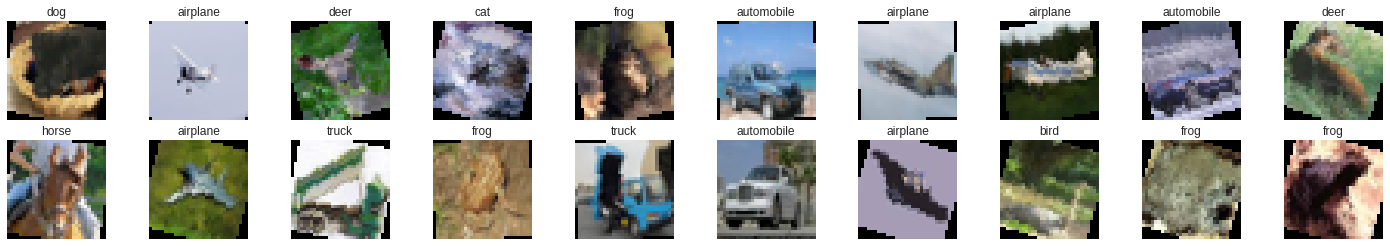

In [45]:
images, labels = next(iter(trainloader))
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

In [61]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Defining the first convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        #Defining the second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #Defining the third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #Defining the Max Pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        #Defining the first fully connnected layer. Why 8*8*16??
        self.fc1 = nn.Linear(64*4*4, 256)
        #Defining the second fully connnected layer
        self.fc2 = nn.Linear(256, 64)
        #Defining the third fully connnected layer
        self.fc3 = nn.Linear(64, 10)
        
        #adding Dropout layer
        self.dropout = nn.Dropout(0.2);
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

model = Net()

if cuda_available:
    model.cuda()

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
#Defining the loss
criterion = nn.CrossEntropyLoss()
#Defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    
    for images, labels in testloader:
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        
        logits = model(images)
        ps = F.softmax(logits, dim=1)
        
        test_loss += criterion(logits, labels).item()
        
        top_k, top_class  = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    return accuracy, test_loss

In [0]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=50):
    
    training_loss = 0
    steps = 0
    valid_min = 1000
    
    for e in range(epochs):
        model.train()
        
        for images, labels in trainloader:
            if cuda_available:
                images, labels = images.cuda(), labels.cuda()
            steps += 1
            optimizer.zero_grad()

            logits = model(images)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
           
        model.eval()
                
        accuracy = 0
        test_loss = 0
        with torch.no_grad():
            accuracy, test_loss = validation(model, testloader, criterion)
                
        print('Epoch {}/{}: '.format(e+1, epochs),
        'Training Loss {:.3f} '.format(training_loss/len(trainloader)),
        'Test Loss {:.3f} '.format(test_loss/len(testloader)),
        'Test Accuracy {:.3f}'.format(accuracy/len(testloader)))
                
        if valid_min>test_loss:
            valid_min=test_loss
            print('Validation loss decreased..Saving Model..')
            torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/Deep Learning/PyTorch Scholarship/CIFAR-10 Project/checkpoint.pth')
                
        training_loss = 0
        model.train()
                

In [65]:
train(model, trainloader, validloader, criterion, optimizer, 40)

Epoch 1/40:  Training Loss 2.302  Test Loss 2.299  Test Accuracy 0.152
Validation loss decreased..Saving Model..
Epoch 2/40:  Training Loss 2.287  Test Loss 2.240  Test Accuracy 0.184
Validation loss decreased..Saving Model..
Epoch 3/40:  Training Loss 2.077  Test Loss 1.925  Test Accuracy 0.291
Validation loss decreased..Saving Model..
Epoch 4/40:  Training Loss 1.857  Test Loss 1.718  Test Accuracy 0.369
Validation loss decreased..Saving Model..
Epoch 5/40:  Training Loss 1.694  Test Loss 1.594  Test Accuracy 0.412
Validation loss decreased..Saving Model..
Epoch 6/40:  Training Loss 1.594  Test Loss 1.564  Test Accuracy 0.424
Validation loss decreased..Saving Model..
Epoch 7/40:  Training Loss 1.526  Test Loss 1.475  Test Accuracy 0.461
Validation loss decreased..Saving Model..
Epoch 8/40:  Training Loss 1.456  Test Loss 1.417  Test Accuracy 0.477
Validation loss decreased..Saving Model..
Epoch 9/40:  Training Loss 1.409  Test Loss 1.339  Test Accuracy 0.518
Validation loss decreased

In [0]:
#Loading the best model
model.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/Deep Learning/PyTorch Scholarship/CIFAR-10 Project/checkpoint.pth'))

In [70]:
#Testing on test data
#accuracy = 0
test_loss = 0

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]
model.eval()
for images, labels in testloader:
    if cuda_available:
        images, labels = images.cuda(), labels.cuda()
        
    logits = model(images)
    ps = F.softmax(logits, dim=1)
        
    test_loss += criterion(logits, labels).item()
        
    top_k, top_class  = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    #accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    if cuda_available:
        equals = equals.cpu().numpy().squeeze()
    else:
        equals = equals.numpy().squeeze()
       
    
    for i in range(len(labels)):
        #print(labels.shape)
        label = labels[i]
        class_correct[label] += equals[i]
        class_total[label] += 1
    
model.train()

print('Test Loss: {}\n'.format(test_loss/len(testloader)))

for i in range(10):
    print('Accuracy for {} is {} : {}/{}'.format(classes[i], 100*class_correct[i]/class_total[i], class_correct[i], class_total[i]))

print('\nTotal Accuracy is {} : {}/{}'.format(100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.8186258914562079

Accuracy for airplane is 79.8 : 798/1000
Accuracy for automobile is 84.0 : 840/1000
Accuracy for bird is 51.4 : 514/1000
Accuracy for cat is 54.9 : 549/1000
Accuracy for deer is 68.6 : 686/1000
Accuracy for dog is 66.4 : 664/1000
Accuracy for frog is 75.4 : 754/1000
Accuracy for horse is 71.9 : 719/1000
Accuracy for ship is 84.1 : 841/1000
Accuracy for truck is 84.1 : 841/1000

Total Accuracy is 72.06 : 7206/10000


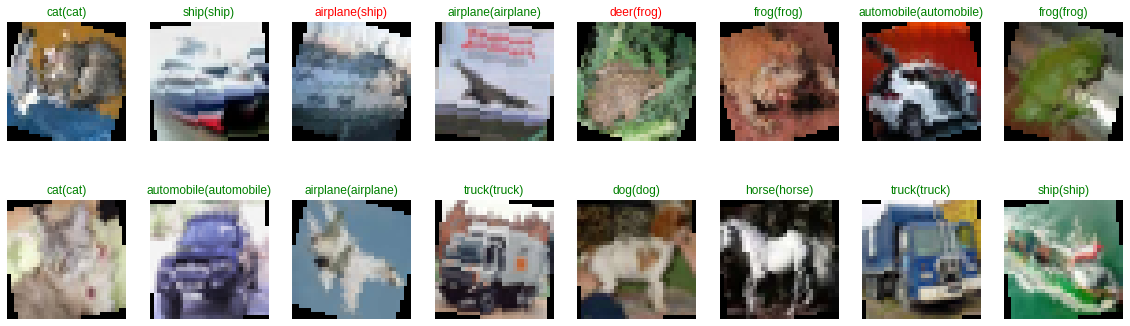

In [71]:
#Visualizing on test set
images, labels = next(iter(testloader))

if cuda_available:
    images = images.cuda()

logits = model(images)
images = images.cpu() #to use images for plotting
top_p, top_class = logits.topk(1, dim=1)

if cuda_available:
    top_class = top_class.cpu().numpy().squeeze()
else:
    top_class = top_class.numpy().squeeze()
    
fig = plt.figure(figsize=(20,6))
for i in range(16):
    ax = fig.add_subplot(2,8,i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title('{}({})'.format(classes[top_class[i]], classes[labels[i]]),
                color = 'green' if top_class[i]==labels[i] else 'red')